# ML Water Explore

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score as metric_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer, PowerTransformer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from collections import Counter

## Setting Key Values

In [2]:
SEED = 1
# Train X
DATA_PATH = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
# Train y
DATA_PATH2 = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
# Test X
DATA_PATH3 = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
TARGET_VARIABLE = 'status_group'
SPLITS = 5
MAX_ITER = 1000
#For metric, import the required library as metric_scorer
METRIC = 'accuracy'

## Data Reading and Exploration
Here we read the data, print its first rows and describe its contents

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

X_train = read_data(DATA_PATH)
y_train = read_data(DATA_PATH2)
X_test = read_data(DATA_PATH3)

X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [30]:
data = X_train.merge(y_train, on = ['id'])

data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


We review the data types for each column

In [31]:
data.dtypes

id                         int64
amount_tsh                object
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

We check if there is any missing data

In [32]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(data).head(10)

,Total,Percent
scheme_name,28166,0.474175
scheme_management,3877,0.065269
installer,3655,0.061532
funder,3635,0.061195
public_meeting,3334,0.056128
permit,3056,0.051448
subvillage,371,0.006246
ward,0,0.000000
lga,0,0.000000
district_code,0,0.000000


We drop unnecessary columns

In [33]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

data = drop_columns(data, ['recorded_by', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']) #'extraction_type_class', 'extraction_type_group', 'management_group'
# maybe include water quality

## Converting Columns to their true type
Now fixing the data types of object columns that are actually categorical and of dates

In [53]:
def convert_to_category(df, cols):
    for i in cols:
        df[i] = df[i].astype('category')
    return df

data = convert_to_category(data, data.iloc[:,13:15])

data = pd.concat([
        data.select_dtypes([], ['object']),
        data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex_axis(data.columns, axis=1)

data['date_recorded'] = pd.to_datetime(data['date_recorded'])

data['amount_tsh'] = pd.to_numeric(data['amount_tsh'])

data.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  # This is added back by InteractiveShellApp.init_path()


id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                         category
gps_height                        int64
installer                      category
longitude                       float64
latitude                        float64
wpt_name                       category
num_private                       int64
basin                          category
subvillage                     category
region                         category
region_code                    category
district_code                  category
lga                            category
ward                           category
population                        int64
public_meeting                 category
scheme_management              category
scheme_name                    category
permit                         category
construction_year                 int64
extraction_type                category
extraction_type_group          category


## Plotting the target variable

In [54]:
data['status_group'].unique()

[functional, non functional, functional needs repair]
Categories (3, object): [functional, non functional, functional needs repair]

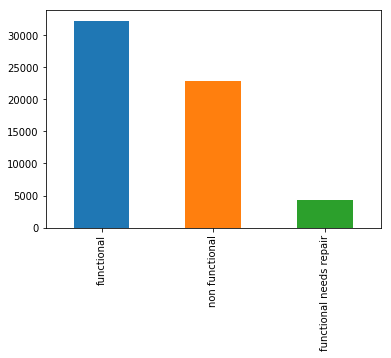

In [25]:
data['status_group'].value_counts().plot(kind='bar')

## Explore distribution of target variable for missing values

In [55]:
vars_with_nan = ['scheme_name', 'scheme_management', 'installer', 'funder', 
                    'public_meeting', 'public_meeting', 'subvillage']

missing_vals = data[vars_with_nan]

In [56]:
mv = pd.DataFrame()
    
mv['overall'] = [len(data[data['status_group'] == 'functional'])/len(data),
                len(data[data['status_group'] == 'non functional'])/len(data),
                len(data[data['status_group'] == 'functional needs repair'])/len(data)]

for col in ['scheme_name', 'scheme_management', 'installer', 'funder', 
                    'public_meeting', 'public_meeting', 'subvillage']:
    mv[col] = [(data[data['status_group'] == 'functional'][col].isnull().sum())/(data[col].isnull().sum()),
              (data[data['status_group'] == 'non functional'][col].isnull().sum())/(data[col].isnull().sum()),
              (data[data['status_group'] == 'functional needs repair'][col].isnull().sum())/(data[col].isnull().sum())]

mv = mv.rename({0: 'functional', 1: 'non functional', 2: 'functional needs repair'})
mv

,overall,scheme_name,scheme_management,installer,funder,public_meeting,subvillage
functional,0.543081,0.514379,0.483105,0.547196,0.544979,0.503299,0.552561
non functional,0.384242,0.414471,0.459376,0.332421,0.334801,0.449910,0.444744
functional needs repair,0.072677,0.071150,0.057519,0.120383,0.120220,0.046791,0.002695


Missing values appear to contain information regarding whether a pump is funcional

Create separate dataframe without nans for EDA

In [17]:
data_complete = data[data.isnull().any(axis=1)==False]
data_incomplete = data[data.isnull().any(axis=1)]
data.describe()

,id,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [57]:
#data_filled = data

#for var in vars_with_nan:
#    data_filled = data_filled[var].cat.add_categories(['missing_value'])
#    data_filled = data_filled.fillna('missing_value')

#data_filled.head()

### Some plots

In [ ]:
#df_plot_1 = 

#sns.lineplot(data = data, x = 'date_recorded', )

**Score a baseline**

In [74]:
my_y_train = data['status_group'].copy()
#my_y_train = pd.get_dummies(my_y_train)


my_X_train = data.copy()
my_X_train = my_X_train.drop(['id', 'status_group', 'funder', 'installer', 'wpt_name', 'subvillage',
                             'region', 'lga', 'ward', 'date_recorded'], axis = 1)
my_X_train = pd.get_dummies(my_X_train)

In [67]:
my_X_train.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,1390,34.938093,-9.856322,0,109,1999,0,1,0,...,0,1,0,0,1,0,0,0,0,0
1,0.0,1399,34.698766,-2.147466,0,280,2010,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,25.0,686,37.460664,-3.821329,0,250,2009,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,0,58,1986,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0,31.130847,-1.825359,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [75]:
my_y_train.head()

0        functional
1        functional
2        functional
3    non functional
4        functional
Name: status_group, dtype: category
Categories (3, object): [functional, functional needs repair, non functional]

In [112]:
logreg = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = 200)
scores = cross_val_score(logreg, my_X_train, my_y_train, cv=5)
scores

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

array([0.73158825, 0.72106725, 0.73367003, 0.72104377, 0.72562721])

Create dataset with fewer variabels

In [116]:
my_y_train = data['status_group'].copy()
#my_y_train = pd.get_dummies(my_y_train)


my_X_train = data.copy()
my_X_train = my_X_train.drop(['id', 'status_group', 'funder', 'installer', 'wpt_name', 'subvillage',
                             'region', 'district_code', 'lga', 'ward', 'date_recorded', 'scheme_name',
                             'extraction_type_class', 'extraction_type_group', 'management_group', ], axis = 1)
my_X_train = pd.get_dummies(my_X_train)

## Create geographical clusters

In [106]:
X_loc=data.loc[:,['latitude','longitude']]

id_n=100
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X_loc)
id_label=kmeans.labels_

In [107]:
data_clustered = data.copy()
data_clustered['cluster'] = id_label
data_clustered.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,extraction_type_class,management,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group,cluster
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,functional,36
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,72
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,functional,13
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,non functional,93
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,68


In [179]:
my_y_train1 = data_clustered['status_group'].copy()

my_X_train1 = data_clustered.copy()
my_X_train1 = my_X_train1.drop(['id', 'status_group', 'funder', 'installer', 'wpt_name', 'subvillage',
                             'region', 'district_code', 'lga', 'ward', 'date_recorded', 'scheme_name',
                             'extraction_type_class', 'extraction_type_group', 'management_group',
                               'latitude', 'longitude'], axis = 1)
my_X_train1 = pd.get_dummies(my_X_train1)

In [211]:
scores = cross_val_score(gbtrees, my_X_train2, my_y_train1, cv=5)
scores

array([0.76087871, 0.76239374, 0.76203704, 0.75883838, 0.76443846])

**Create some features**

In [209]:
def time_since_recorded(df):
    df['time_since_recorded'] = (pd.to_datetime('2013-12-31') - df['date_recorded'])/100000000000
    df['time_since_recorded'] = pd.to_numeric(df['time_since_recorded'])
    df = df.drop('date_recorded', axis=1)
    return df

def time_since_construction(df):
    df['time_since_construction'] = 2014 - df['construction_year']
    return df

def amount_tsh_zero(df):
    df['amount_tsh'] = ((df['amount_tsh'] + 1) == True)
    return df

def missing_scheme_name(df):
    df['missing_scheme_name'] = (df['scheme_name'].isnull() == True)
    df = df.drop('scheme_name', axis=1)
    return df

def missing_installer(df):
    df['missing_installer'] = (df['installer'].isnull() == True)
    df = df.drop('installer', axis=1)
    return df

def missing_funder(df):
    df['missing_funder'] = (df['funder'].isnull() == True)
    df = df.drop('funder', axis=1)
    return df

def missing_public_meeting(df):
    df['missing_public_meeting'] = (df['public_meeting'].isnull() == True)
    df = df.drop('public_meeting', axis=1)
    return df

def missing_subvillage(df):
    df['missing_subvillage'] = (df['subvillage'].isnull() == True)
    df = df.drop('subvillage', axis=1)
    return df

Keep most common category levels

In [221]:
data.groupby(['funder']).agg('count').sort_values(by = 'id', ascending = False)

,id,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,extraction_type_group,extraction_type_class,management,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group
funder,,,,,,,,,,,,,,,,,,,,,
Government Of Tanzania,9084,9084,9084,9084,9080,9084,9084,9084,9084,9084,...,9084,9084,9084,9084,9084,9084,9084,9084,9084,9084
Danida,3114,3114,3114,3114,3114,3114,3114,3114,3114,3114,...,3114,3114,3114,3114,3114,3114,3114,3114,3114,3114
Hesawa,2202,2202,2202,2202,2197,2202,2202,2202,2202,2202,...,2202,2202,2202,2202,2202,2202,2202,2202,2202,2202
Rwssp,1374,1374,1374,1374,1373,1374,1374,1374,1374,1374,...,1374,1374,1374,1374,1374,1374,1374,1374,1374,1374
World Bank,1349,1349,1349,1349,1338,1349,1349,1349,1349,1349,...,1349,1349,1349,1349,1349,1349,1349,1349,1349,1349
Kkkt,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,...,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287
World Vision,1246,1246,1246,1246,1239,1246,1246,1246,1246,1246,...,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246
Unicef,1057,1057,1057,1057,1057,1057,1057,1057,1057,1057,...,1057,1057,1057,1057,1057,1057,1057,1057,1057,1057
Tasaf,877,877,877,877,876,877,877,877,877,877,...,877,877,877,877,877,877,877,877,877,877


In [210]:
my_y_train2 = data_clustered['status_group'].copy()

my_X_train2 = data_clustered.copy()
my_X_train2 = my_X_train2.drop(['id','wpt_name', 'scheme_name', 'installer', 'status_group',
                             'region', 'district_code', 'lga', 'ward',
                             'extraction_type_class', 'extraction_type_group', 'management_group',
                               'latitude', 'longitude'], axis = 1)

my_X_train2 = time_since_recorded(my_X_train2)
my_X_train2 = time_since_construction(my_X_train2)
my_X_train2 = amount_tsh_zero(my_X_train2)
my_X_train2 = missing_funder(my_X_train2)
my_X_train2 = missing_public_meeting(my_X_train2)
my_X_train2 = missing_subvillage(my_X_train2)

my_X_train2 = pd.get_dummies(my_X_train2)

In [171]:
my_X_train2.dtypes

amount_tsh                                      bool
gps_height                                     int64
num_private                                    int64
population                                     int64
construction_year                              int64
cluster                                        int32
basin_Internal                                 uint8
basin_Lake Nyasa                               uint8
basin_Lake Rukwa                               uint8
basin_Lake Tanganyika                          uint8
basin_Lake Victoria                            uint8
basin_Pangani                                  uint8
basin_Rufiji                                   uint8
basin_Ruvuma / Southern Coast                  uint8
basin_Wami / Ruvu                              uint8
region_code_1                                  uint8
region_code_2                                  uint8
region_code_3                                  uint8
region_code_4                                 

## Data Correlation
Now we will look at correlation, both numerical and categorical and plot them

In [44]:
def numerical_correlated(df, threshold=0.9):
    corr_matrix = np.absolute(df.select_dtypes(include=[np.number]).corr(method='spearman')).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr_matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

def categorical_correlated(df, threshold=0.9):
    columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df[columns[i]], df[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr


#def correlated(df, threshold=0.9):
#    return (categorical_correlated(df, threshold), numerical_correlated(df, threshold))
def correlated(df, threshold=0.9):
    return (numerical_correlated(df, threshold))

correlated_cols = correlated(data, 0.7)

#if(len(correlated_cols[0][0]) + len(correlated_cols[1][0]) > 0):
#    print('The following columns are correlated: ' + str(correlated_cols[0][0] + correlated_cols[1][0]))
#else:
#    print('No correlated columns for the selected threshold')

Plot the categorical columns

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[0][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

Plot the numerical columns

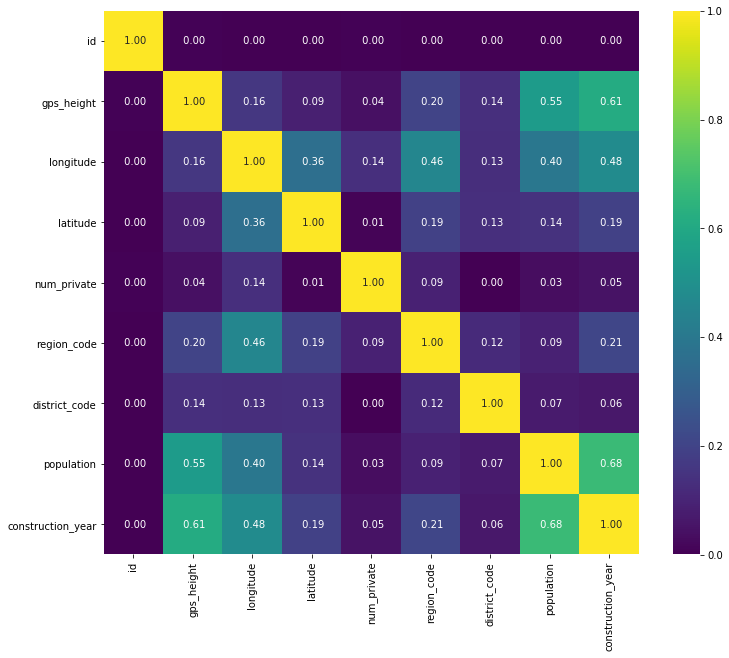

In [45]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

## Adding Registered Customers Lag

In [117]:
#def add_lag(df, cols, lags):
#     new_cols = []
#     for col in cols:
#         for lag in lags:
#             new_col = df['registered'].shift(-lag).rename(str(col) + '_' + str(lag))
#             new_cols.append(new_col) 
#     df = pd.concat([df, new_cols], axis = 1)
#     return df

# data = add_lag(data, ['registered'], [1,24])
# holdout = add_lag(data, ['registered'], [1,24])

# registered_1 = data['registered'].shift(-1).rename("registered_1")
# registered_24 = data['registered'].shift(-24).rename("registered_24")
# data = pd.concat([data, registered_1, registered_24], axis = 1)

# registered_1 = holdout['registered'].shift(-1).rename("registered_1")
# registered_24 = holdout['registered'].shift(-24).rename("registered_24")
# holdout = pd.concat([holdout, registered_1, registered_24], axis = 1)

# data.head()

## Dropping Selected Correlated Columns

In [118]:
data = drop_columns(data, ['season', 'workingday', 'temp', 'registered'])
holdout = drop_columns(holdout, ['season', 'workingday', 'temp', 'registered'])
data.head()

,dteday,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,registered_24
0,2011-01-01,0,1,0,0,6,1,0.2879,0.81,0.0,16,12.9
1,2011-01-01,0,1,1,0,6,1,0.2727,0.80,0.0,40,31.9
2,2011-01-01,0,1,2,0,6,1,0.2727,0.80,0.0,32,26.9
3,2011-01-01,0,1,3,0,6,1,0.2879,0.75,0.0,13,9.9
4,2011-01-01,0,1,4,0,6,1,0.2879,0.75,0.0,1,0.9


## Extracting Day Variable

In [119]:
def extract_day(df):
    df['day'] = df['dteday'].dt.day
    df = convert_to_category(df, ['day'])
    df = drop_columns(df, ['dteday'])
    return df

data = extract_day(data)
holdout = extract_day(holdout)
data.head()

,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,registered_24,day
0,0,1,0,0,6,1,0.2879,0.81,0.0,16,12.9,1
1,0,1,1,0,6,1,0.2727,0.80,0.0,40,31.9,1
2,0,1,2,0,6,1,0.2727,0.80,0.0,32,26.9,1
3,0,1,3,0,6,1,0.2879,0.75,0.0,13,9.9,1
4,0,1,4,0,6,1,0.2879,0.75,0.0,1,0.9,1


## Fixing Data Skewness and Standardizing
Now we will fix skewness if present and standardize numerical features

In [120]:
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(data.iloc[:,6:9])
data.iloc[:,6:9] = pt.transform(data.iloc[:,6:9])
holdout.iloc[:,6:9] = pt.transform(holdout.iloc[:,6:9])
data.head()

,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,registered_24,day
0,0,1,0,0,6,1,-1.147773,0.945987,-1.781706,16,12.9,1
1,0,1,1,0,6,1,-1.225548,0.893007,-1.781706,40,31.9,1
2,0,1,2,0,6,1,-1.225548,0.893007,-1.781706,32,26.9,1
3,0,1,3,0,6,1,-1.147773,0.629503,-1.781706,13,9.9,1
4,0,1,4,0,6,1,-1.147773,0.629503,-1.781706,1,0.9,1


## Outlier Winsorizing
Now we will winsorize outliers

In [121]:
def winsorize_data(df, cols):
    df[cols.columns] = winsorize(df[cols.columns], limits = [0.01, 0.01])
    return df

data = winsorize_data(data, data.iloc[:,np.r_[:,6:9]])

data.describe()

,atemp,hum,windspeed,cnt,registered_24
count,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000
mean,-0.000480,0.003864,-0.007738,185.225232,148.709066
std,0.988445,0.991477,0.981681,177.918222,146.852050
min,-1.889375,-1.889375,-1.781706,1.000000,-0.100000
25%,-0.911043,-0.801054,-0.680979,39.000000,33.000000
50%,0.014506,-0.044433,0.116538,138.000000,111.000000
75%,0.742192,0.787325,0.588581,275.000000,213.000000
max,2.021428,1.969779,2.021428,977.000000,886.000000


## Underrepresented Features
Now we will see underrepresented features

In [122]:
def under_represented_features(df, threshold = 0.85):
    under_rep = []
    for column in df.select_dtypes(include=["object"]):
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
    return under_rep

under_represented = under_represented_features(data)

if not under_represented:
    print('No underrepresented features')
else:
    print(str(under_represented) + ' are underrepresented, removing them')
    data = drop_columns(data, [x for x in under_represented if data.columns[x]!= TARGET_VARIABLE])
    data.head()

No underrepresented features


## Cross Validation
Now we will perform cross validation

In [123]:
def cv_evaluate(df, splits = 10, model = None, transformers = None, final = False, skipGrid = True):
    kfolds = KFold(n_splits = splits, shuffle=True, random_state = SEED)
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state= SEED)
    if model is None:
        model = LinearRegression()
        if transformers is None:
            model = make_pipeline(model)
        else:
            model = make_pipeline(model)
            for ind,i in enumerate(transformers):
                model.steps.insert(ind,[str(ind+1),i])
    
    if final:
        if skipGrid:
            model = LinearRegression()
            model = make_pipeline(model)
            for ind,i in enumerate(transformers):
                model.steps.insert(ind,[str(ind+1),i])
            scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = kfolds)
            model.fit(X_train, y_train)
        else: 
            #grid={'logisticregression__C':[0.01, 0.1, 1, 10], 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'logisticregression__penalty':['l1','l2'], 'logisticregression__dual': [True, False], 'logisticregression__random_state': [SEED, SEED + 1, SEED + 2]}
            #model = GridSearchCV(model, grid, scoring = METRIC, cv= kfolds, refit=True, return_train_score = False, error_score=0.0)
            model.fit(X_train, y_train)
            scores = model.cv_results_['mean_test_score']
        sns.distplot(scores[scores > 0.0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
        plt.title('Distribution of ' + METRIC + ' scores while performing Grid Search')
        plt.show()
    else:
        scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = kfolds)
        model.fit(X_train, y_train)

    pred = model.predict(X_validate)
    final_score = metric_scorer(y_validate, pred)
    
    return final_score, scores, model

## Feature Selection
Now we will do feature selection to determine which features to keep

Feature ranking:


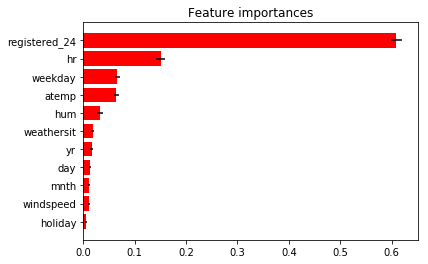

[8, 1, 10, 0, 5, 7, 6, 4, 2, 9]

In [124]:
def feature_importance(df, ratio = 0.01, plot = False):
    forest = RandomForestRegressor(n_estimators=100, random_state = SEED)
    acc, scores, forest = cv_evaluate(df, model = forest)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)
    
    if plot:
        X = df.loc[:, df.columns != TARGET_VARIABLE]
        print("Feature ranking:")
        plt.figure()
        plt.title("Feature importances")
        plt.barh(range(X.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
        plt.yticks(range(X.shape[1]), [list(df.loc[:, df.columns != TARGET_VARIABLE])[i] for i in indices])
        plt.ylim([-1, X.shape[1]])
        plt.show()
    
    
    keep = [x for x in indices if importances[x] > ratio]
    target = df.columns.get_loc(TARGET_VARIABLE)
    if target not in keep:
        keep.append(target)
        
    return keep

feature_importance(data, plot = True)

## Principal Component Analysis (PCA)
We will plot PCA component variance

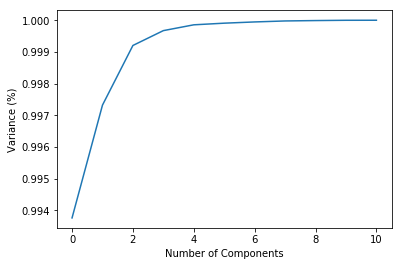

2

In [125]:
def plot_pca_components(df, variance = 0.9):
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    pca = PCA()
    X = pca.fit_transform(X)
    pca = PCA().fit(X)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.show()
    
    count = 0
    
    for ind, i in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if count < variance:
            count += i
        else:
            return ind + 1
        
plot_pca_components(data)

## Pipeline Function
The pipeline will decide which functions to keep and which not to based on if they improve the score

In [126]:
def feature_engineering_pipeline(df, transformers):
    selected_transformers = []
    
    base_score, scores, models = cv_evaluate(df)
    all_scores  = pd.DataFrame(columns = ['Function', 'CV Score', 'Holdout Score', 'Difference', 'Outcome'])
    all_scores = all_scores.append({'Function':'base_score','CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': base_score, 'Difference': 0, 'Outcome': 'Base'}, ignore_index=True)
    
    engineered_data = df.copy()
                                    
    for transformer in transformers:
        outcome = 'Rejected'
        
        new_score, scores, model = cv_evaluate(engineered_data, transformers = [transformer[1]])

        difference = (new_score - base_score)
                         
        if difference > 0.005:
            selected_transformers.append(transformer[1])
            base_score = new_score
            outcome = 'Accepted'

        score = { 'Function':transformer[0],'CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': new_score, 'Difference': difference, 'Outcome': outcome}
        
        all_scores = all_scores.append(score, ignore_index=True)
            
    return selected_transformers, all_scores

## Running the Pipeline
Here we will run the pipeline

In [127]:
transformers = [
    ('rfe', RFE(RandomForestRegressor(n_estimators=10, random_state = SEED))),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state = SEED), threshold = 0.01)),
    ('binning', KBinsDiscretizer(n_bins=5, encode='onehot')),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(.95))
]

final_transformers, all_scores = feature_engineering_pipeline(data, transformers)

if len(final_transformers) > 0:
    holdout_score, scores, model = cv_evaluate(data, splits = SPLITS, transformers = final_transformers)
else:
    holdout_score, scores, model = cv_evaluate(data, splits = SPLITS)
score = { 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])), 'Holdout Score': "{0:.3f}".format(holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_scores = all_scores.append(score, ignore_index=True)

## Scores
Here you can see all of the scores

In [128]:
all_scores

,Function,CV Score,Holdout Score,Difference,Outcome
0,base_score,0.71 +/- 0.021,0.712444,0,Base
1,rfe,0.70 +/- 0.021,0.706489,-0.00595556,Rejected
2,feature_selection,0.71 +/- 0.021,0.712442,-1.8159e-06,Rejected
3,binning,0.66 +/- 0.016,0.673228,-0.039216,Rejected
4,polynomial,0.76 +/- 0.015,0.765817,0.0533726,Accepted
5,pca,0.64 +/- 0.026,0.652079,-0.113738,Rejected
6,cross_evaluate,0.759 +/- 0.0058,0.766,0,Final Cross Validation


In [129]:
#This should be uncommented when you run GridSearch
#final_model = model.best_estimator_
#model.best_params_

#This should be removed after
final_model = model

# Final Score
This is the final score of the model

In [131]:
X_train = data.loc[:, data.columns != TARGET_VARIABLE]
y_train = data.loc[:, TARGET_VARIABLE]
final_model.fit(X_train, y_train)
X = holdout.loc[:, holdout.columns != TARGET_VARIABLE]
y = holdout.loc[:, TARGET_VARIABLE]
pred = final_model.predict(X)
score = metric_scorer(y,pred)
print(score)

0.6958407579018022


## Plot of Predictions

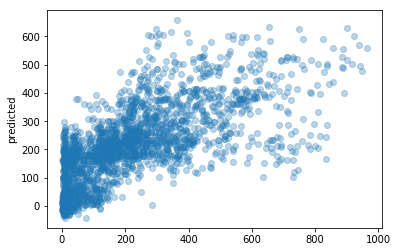

In [28]:
plt.scatter(y, pred, alpha=0.3)
plt.ylabel('predicted')
plt.show()